In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
os.listdir('../input/cassava-leaf-disease-classification')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
label_map = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


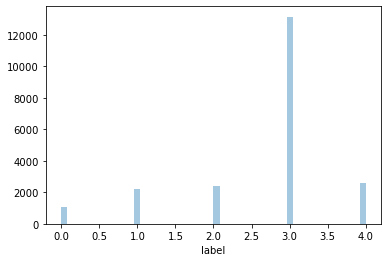

In [4]:
sns.distplot(train['label'], kde=False)

In [5]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
TEST_PATH = '../input/cassava-leaf-disease-classification/test_images'

In [6]:
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='resnext50_32x4d'
    size=256
    scheduler='ReduceLROnPlateau' # ['CosineAnnealingWarmRestarts', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    factor=0.2 # ReduceLROnPlateau
    patience=4 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    #T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [7]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, RandomRotate90, CoarseDropout, OpticalDistortion, HueSaturationValue, RandomBrightnessContrast
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [10]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [11]:
train_dataset = TrainDataset(train, transform=None)

# for i in range(1):
#     image, label = train_dataset[i]
#     plt.imshow(image)
#     plt.title(f'label: {label}')
#     plt.show() 

In [12]:
def get_transforms(*, data):
    num_holes = 50
    max_width = int(((CFG.size*CFG.size)/(num_holes*10))**(1/2))
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            CoarseDropout(num_holes, max_width, max_width, p=0.5),
            RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

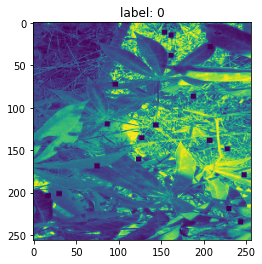

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [14]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.2510, -0.0262,  0.0266,  0.3416, -0.0656],
        [ 0.1314,  0.0629,  0.0426,  0.6245,  0.1267],
        [ 0.0892,  0.0820,  0.0485,  0.3608,  0.0199],
        [ 0.0525,  0.0910,  0.0889,  0.5509,  0.0408]],
       grad_fn=<AddmmBackward>)


In [16]:
model

CustomResNext(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [19]:
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [20]:
def main():

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [21]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


Epoch: [1][0/534] Data 1.657 (1.657) Elapsed 0m 3s (remain 29m 25s) Loss: 1.5144(1.5144) Grad: 8.2534  
Epoch: [1][100/534] Data 0.000 (0.017) Elapsed 0m 43s (remain 3m 5s) Loss: 0.9327(0.8389) Grad: 12.1620  
Epoch: [1][200/534] Data 0.000 (0.009) Elapsed 1m 23s (remain 2m 17s) Loss: 0.3283(0.7393) Grad: 5.3923  
Epoch: [1][300/534] Data 0.000 (0.006) Elapsed 2m 3s (remain 1m 35s) Loss: 0.4969(0.6861) Grad: 7.9599  
Epoch: [1][400/534] Data 0.000 (0.005) Elapsed 2m 43s (remain 0m 54s) Loss: 0.6107(0.6516) Grad: 7.6257  
Epoch: [1][500/534] Data 0.000 (0.004) Elapsed 3m 23s (remain 0m 13s) Loss: 0.7106(0.6310) Grad: 8.0431  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 3m 36s (remain 0m 0s) Loss: 0.6648(0.6254) Grad: 6.5978  
EVAL: [0/134] Data 1.238 (1.238) Elapsed 0m 1s (remain 2m 57s) Loss: 0.6049(0.6049) 
EVAL: [100/134] Data 0.290 (0.188) Elapsed 0m 28s (remain 0m 9s) Loss: 0.7488(0.5086) 


Epoch 1 - avg_train_loss: 0.6254  avg_val_loss: 0.5048  time: 253s
Epoch 1 - Accuracy: 0.8242990654205608
Epoch 1 - Save Best Score: 0.8243 Model


EVAL: [133/134] Data 0.000 (0.181) Elapsed 0m 37s (remain 0m 0s) Loss: 0.6583(0.5048) 
Epoch: [2][0/534] Data 1.478 (1.478) Elapsed 0m 2s (remain 18m 15s) Loss: 0.5145(0.5145) Grad: 5.0797  
Epoch: [2][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3606(0.5080) Grad: 5.4680  
Epoch: [2][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.6142(0.5075) Grad: 7.4711  
Epoch: [2][300/534] Data 0.000 (0.006) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4782(0.4944) Grad: 5.1761  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.3339(0.4950) Grad: 4.2261  
Epoch: [2][500/534] Data 0.001 (0.004) Elapsed 3m 17s (remain 0m 13s) Loss: 0.7108(0.4967) Grad: 7.1604  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.6051(0.4943) Grad: 6.1565  
EVAL: [0/134] Data 1.105 (1.105) Elapsed 0m 1s (remain 2m 40s) Loss: 0.6660(0.6660) 
EVAL: [100/134] Data 0.435 (0.162) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4689(0.4714) 


Epoch 2 - avg_train_loss: 0.4943  avg_val_loss: 0.4717  time: 246s
Epoch 2 - Accuracy: 0.85
Epoch 2 - Save Best Score: 0.8500 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6133(0.4717) 
Epoch: [3][0/534] Data 1.264 (1.264) Elapsed 0m 1s (remain 14m 56s) Loss: 0.3181(0.3181) Grad: 4.0853  
Epoch: [3][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3457(0.4316) Grad: 4.2380  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4210(0.4516) Grad: 4.8994  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4355(0.4642) Grad: 5.3359  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.3113(0.4607) Grad: 3.6979  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.4010(0.4598) Grad: 5.2274  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.6118(0.4611) Grad: 5.9302  
EVAL: [0/134] Data 1.013 (1.013) Elapsed 0m 1s (remain 2m 27s) Loss: 0.5921(0.5921) 
EVAL: [100/134] Data 0.387 (0.157) Elapsed 0m 25s (remain 0m 8s) Loss: 0.6798(0.4470) 


Epoch 3 - avg_train_loss: 0.4611  avg_val_loss: 0.4407  time: 245s
Epoch 3 - Accuracy: 0.8551401869158879
Epoch 3 - Save Best Score: 0.8551 Model


EVAL: [133/134] Data 0.000 (0.156) Elapsed 0m 33s (remain 0m 0s) Loss: 0.6799(0.4407) 
Epoch: [4][0/534] Data 1.141 (1.141) Elapsed 0m 1s (remain 14m 23s) Loss: 0.7072(0.7072) Grad: 6.7045  
Epoch: [4][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 57s) Loss: 0.5648(0.4427) Grad: 4.6809  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.6699(0.4506) Grad: 6.7793  
Epoch: [4][300/534] Data 0.006 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2266(0.4512) Grad: 2.5822  
Epoch: [4][400/534] Data 0.008 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.2532(0.4467) Grad: 2.9137  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3912(0.4476) Grad: 4.0940  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.4822(0.4453) Grad: 4.7685  
EVAL: [0/134] Data 1.092 (1.092) Elapsed 0m 1s (remain 2m 37s) Loss: 0.5623(0.5623) 
EVAL: [100/134] Data 0.525 (0.168) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4330(0.4219) 


Epoch 4 - avg_train_loss: 0.4453  avg_val_loss: 0.4195  time: 244s
Epoch 4 - Accuracy: 0.8663551401869158
Epoch 4 - Save Best Score: 0.8664 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 33s (remain 0m 0s) Loss: 0.6196(0.4195) 
Epoch: [5][0/534] Data 1.558 (1.558) Elapsed 0m 2s (remain 18m 2s) Loss: 0.4419(0.4419) Grad: 5.6287  
Epoch: [5][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 59s) Loss: 0.3180(0.4179) Grad: 3.8768  
Epoch: [5][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.6005(0.4294) Grad: 5.9227  
Epoch: [5][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.4514(0.4366) Grad: 4.2189  
Epoch: [5][400/534] Data 0.000 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.5338(0.4333) Grad: 4.9522  
Epoch: [5][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.4311(0.4292) Grad: 4.6339  
Epoch: [5][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.7145(0.4267) Grad: 4.7904  
EVAL: [0/134] Data 1.103 (1.103) Elapsed 0m 1s (remain 2m 39s) Loss: 0.5502(0.5502) 
EVAL: [100/134] Data 0.614 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5560(0.4532) 


Epoch 5 - avg_train_loss: 0.4267  avg_val_loss: 0.4444  time: 246s
Epoch 5 - Accuracy: 0.8476635514018691


EVAL: [133/134] Data 0.000 (0.160) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6626(0.4444) 
Epoch: [6][0/534] Data 1.268 (1.268) Elapsed 0m 1s (remain 15m 17s) Loss: 0.4813(0.4813) Grad: 4.9162  
Epoch: [6][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 55s) Loss: 0.4383(0.3965) Grad: 4.9143  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 12s) Loss: 0.5509(0.3954) Grad: 5.8919  
Epoch: [6][300/534] Data 0.005 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.7965(0.4016) Grad: 6.1215  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4644(0.4089) Grad: 3.3467  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3458(0.4154) Grad: 4.4382  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2540(0.4180) Grad: 2.8557  
EVAL: [0/134] Data 1.095 (1.095) Elapsed 0m 1s (remain 2m 38s) Loss: 0.5595(0.5595) 
EVAL: [100/134] Data 0.876 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3878(0.4034) 


Epoch 6 - avg_train_loss: 0.4180  avg_val_loss: 0.3976  time: 245s
Epoch 6 - Accuracy: 0.8696261682242991
Epoch 6 - Save Best Score: 0.8696 Model


EVAL: [133/134] Data 0.000 (0.162) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6010(0.3976) 
Epoch: [7][0/534] Data 1.404 (1.404) Elapsed 0m 1s (remain 16m 57s) Loss: 0.3543(0.3543) Grad: 3.6288  
Epoch: [7][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 57s) Loss: 0.1554(0.3920) Grad: 2.0523  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2659(0.4041) Grad: 3.6487  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.6866(0.4007) Grad: 4.7078  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 37s (remain 0m 52s) Loss: 0.2885(0.4038) Grad: 3.1005  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.3188(0.4079) Grad: 4.1906  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.4493(0.4061) Grad: 4.6622  
EVAL: [0/134] Data 1.053 (1.053) Elapsed 0m 1s (remain 2m 32s) Loss: 0.4911(0.4911) 
EVAL: [100/134] Data 0.615 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.5318(0.4148) 


Epoch 7 - avg_train_loss: 0.4061  avg_val_loss: 0.4127  time: 245s
Epoch 7 - Accuracy: 0.8635514018691589


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5871(0.4127) 
Epoch: [8][0/534] Data 1.420 (1.420) Elapsed 0m 1s (remain 16m 42s) Loss: 0.4361(0.4361) Grad: 3.2963  
Epoch: [8][100/534] Data 0.000 (0.015) Elapsed 0m 40s (remain 2m 55s) Loss: 0.4373(0.3941) Grad: 5.6227  
Epoch: [8][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 12s) Loss: 0.3471(0.4014) Grad: 3.7992  
Epoch: [8][300/534] Data 0.002 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4097(0.4025) Grad: 3.9975  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4787(0.4039) Grad: 5.2166  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 3m 17s (remain 0m 13s) Loss: 0.4555(0.4036) Grad: 4.1464  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3033(0.4057) Grad: 3.7098  
EVAL: [0/134] Data 1.162 (1.162) Elapsed 0m 1s (remain 2m 46s) Loss: 0.5670(0.5670) 
EVAL: [100/134] Data 0.560 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4385(0.4122) 


Epoch 8 - avg_train_loss: 0.4057  avg_val_loss: 0.4106  time: 245s
Epoch 8 - Accuracy: 0.8630841121495327


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5739(0.4106) 
Epoch: [9][0/534] Data 1.204 (1.204) Elapsed 0m 1s (remain 14m 22s) Loss: 0.4719(0.4719) Grad: 3.9177  
Epoch: [9][100/534] Data 0.003 (0.013) Elapsed 0m 41s (remain 2m 55s) Loss: 0.4368(0.3735) Grad: 4.2232  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4018(0.3814) Grad: 3.7131  
Epoch: [9][300/534] Data 0.002 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4403(0.3877) Grad: 4.4379  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 2m 37s (remain 0m 52s) Loss: 0.4913(0.3885) Grad: 4.8063  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 12s) Loss: 0.4654(0.3843) Grad: 4.6773  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 29s (remain 0m 0s) Loss: 0.3300(0.3848) Grad: 4.3283  
EVAL: [0/134] Data 1.089 (1.089) Elapsed 0m 1s (remain 2m 38s) Loss: 0.5622(0.5622) 
EVAL: [100/134] Data 0.625 (0.175) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4997(0.4445) 


Epoch 9 - avg_train_loss: 0.3848  avg_val_loss: 0.4355  time: 245s
Epoch 9 - Accuracy: 0.8539719626168224


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5291(0.4355) 
Epoch: [10][0/534] Data 1.175 (1.175) Elapsed 0m 1s (remain 14m 21s) Loss: 0.3913(0.3913) Grad: 3.9671  
Epoch: [10][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 56s) Loss: 0.3853(0.3796) Grad: 3.7287  
Epoch: [10][200/534] Data 0.000 (0.006) Elapsed 1m 19s (remain 2m 12s) Loss: 0.3916(0.3818) Grad: 3.5857  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3130(0.3777) Grad: 3.3572  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3756(0.3812) Grad: 3.5653  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.3398(0.3847) Grad: 3.0924  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 29s (remain 0m 0s) Loss: 0.4416(0.3851) Grad: 4.3174  
EVAL: [0/134] Data 1.115 (1.115) Elapsed 0m 1s (remain 2m 41s) Loss: 0.4916(0.4916) 
EVAL: [100/134] Data 0.771 (0.177) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4191(0.41

Epoch 10 - avg_train_loss: 0.3851  avg_val_loss: 0.4091  time: 245s
Epoch 10 - Accuracy: 0.8698598130841122
Epoch 10 - Save Best Score: 0.8699 Model


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5431(0.4091) 


========== fold: 0 result ==========
Score: 0.86986
========== fold: 1 training ==========


Epoch: [1][0/534] Data 1.394 (1.394) Elapsed 0m 1s (remain 16m 52s) Loss: 1.5897(1.5897) Grad: 7.4518  
Epoch: [1][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 57s) Loss: 0.5908(0.8769) Grad: 8.6666  
Epoch: [1][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 12s) Loss: 0.6036(0.7645) Grad: 7.9425  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4155(0.7046) Grad: 5.0785  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.5354(0.6710) Grad: 6.5925  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 12s) Loss: 0.4079(0.6418) Grad: 5.4334  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 29s (remain 0m 0s) Loss: 0.5349(0.6360) Grad: 5.7201  
EVAL: [0/134] Data 1.031 (1.031) Elapsed 0m 1s (remain 2m 30s) Loss: 0.3793(0.3793) 
EVAL: [100/134] Data 0.580 (0.175) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5218(0.4719) 


Epoch 1 - avg_train_loss: 0.6360  avg_val_loss: 0.4661  time: 245s
Epoch 1 - Accuracy: 0.841588785046729
Epoch 1 - Save Best Score: 0.8416 Model


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1973(0.4661) 
Epoch: [2][0/534] Data 1.168 (1.168) Elapsed 0m 1s (remain 14m 6s) Loss: 0.3628(0.3628) Grad: 4.7190  
Epoch: [2][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 57s) Loss: 0.5179(0.5090) Grad: 5.6196  
Epoch: [2][200/534] Data 0.003 (0.006) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5771(0.5103) Grad: 6.5075  
Epoch: [2][300/534] Data 0.000 (0.004) Elapsed 2m 0s (remain 1m 32s) Loss: 0.3503(0.4926) Grad: 3.4452  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2529(0.4862) Grad: 5.3052  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.6975(0.4915) Grad: 7.1145  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.5803(0.4919) Grad: 6.5959  
EVAL: [0/134] Data 1.130 (1.130) Elapsed 0m 1s (remain 2m 43s) Loss: 0.4603(0.4603) 
EVAL: [100/134] Data 0.568 (0.162) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3961(0.4274) 


Epoch 2 - avg_train_loss: 0.4919  avg_val_loss: 0.4227  time: 245s
Epoch 2 - Accuracy: 0.8516355140186916
Epoch 2 - Save Best Score: 0.8516 Model


EVAL: [133/134] Data 0.000 (0.158) Elapsed 0m 34s (remain 0m 0s) Loss: 0.1296(0.4227) 
Epoch: [3][0/534] Data 1.192 (1.192) Elapsed 0m 1s (remain 14m 39s) Loss: 0.4475(0.4475) Grad: 5.7509  
Epoch: [3][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 57s) Loss: 0.5729(0.4844) Grad: 5.0268  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.5971(0.4802) Grad: 6.2371  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3570(0.4656) Grad: 4.3375  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3911(0.4644) Grad: 4.7050  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.4920(0.4650) Grad: 4.6005  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3889(0.4633) Grad: 5.5539  
EVAL: [0/134] Data 1.178 (1.178) Elapsed 0m 1s (remain 2m 49s) Loss: 0.3183(0.3183) 
EVAL: [100/134] Data 0.766 (0.168) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3998(0.3917) 


Epoch 3 - avg_train_loss: 0.4633  avg_val_loss: 0.3919  time: 245s
Epoch 3 - Accuracy: 0.8710280373831776
Epoch 3 - Save Best Score: 0.8710 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0616(0.3919) 
Epoch: [4][0/534] Data 1.291 (1.291) Elapsed 0m 1s (remain 15m 12s) Loss: 0.2372(0.2372) Grad: 4.3575  
Epoch: [4][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.5123(0.4579) Grad: 4.8721  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3742(0.4446) Grad: 4.3225  
Epoch: [4][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 32s) Loss: 0.3749(0.4500) Grad: 4.4033  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.3859(0.4463) Grad: 5.0044  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.7454(0.4506) Grad: 7.7495  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.6282(0.4483) Grad: 5.5480  
EVAL: [0/134] Data 1.512 (1.512) Elapsed 0m 1s (remain 3m 33s) Loss: 0.3528(0.3528) 
EVAL: [100/134] Data 0.474 (0.165) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3648(0.3964) 


Epoch 4 - avg_train_loss: 0.4483  avg_val_loss: 0.3910  time: 246s
Epoch 4 - Accuracy: 0.877803738317757
Epoch 4 - Save Best Score: 0.8778 Model


EVAL: [133/134] Data 0.000 (0.160) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0881(0.3910) 
Epoch: [5][0/534] Data 1.306 (1.306) Elapsed 0m 1s (remain 15m 15s) Loss: 0.1547(0.1547) Grad: 1.7002  
Epoch: [5][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 55s) Loss: 0.3479(0.4391) Grad: 3.9575  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.5464(0.4366) Grad: 6.4805  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 1m 58s (remain 1m 31s) Loss: 0.4664(0.4375) Grad: 3.0477  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.6575(0.4348) Grad: 5.1161  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.1943(0.4291) Grad: 2.2147  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 29s (remain 0m 0s) Loss: 0.6174(0.4300) Grad: 5.3330  
EVAL: [0/134] Data 1.111 (1.111) Elapsed 0m 1s (remain 2m 40s) Loss: 0.4345(0.4345) 
EVAL: [100/134] Data 0.614 (0.170) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3896(0.4082) 


Epoch 5 - avg_train_loss: 0.4300  avg_val_loss: 0.4018  time: 244s
Epoch 5 - Accuracy: 0.8623831775700934


EVAL: [133/134] Data 0.000 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.1004(0.4018) 
Epoch: [6][0/534] Data 1.251 (1.251) Elapsed 0m 1s (remain 14m 55s) Loss: 0.3246(0.3246) Grad: 3.9017  
Epoch: [6][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3498(0.4146) Grad: 3.5690  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2311(0.4184) Grad: 3.3418  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4784(0.4138) Grad: 4.6618  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3758(0.4153) Grad: 3.7172  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.4144(0.4183) Grad: 3.4514  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2748(0.4159) Grad: 2.8209  
EVAL: [0/134] Data 1.149 (1.149) Elapsed 0m 1s (remain 2m 46s) Loss: 0.2956(0.2956) 
EVAL: [100/134] Data 0.549 (0.163) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3708(0.3843) 


Epoch 6 - avg_train_loss: 0.4159  avg_val_loss: 0.3799  time: 246s
Epoch 6 - Accuracy: 0.8740654205607477


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0763(0.3799) 
Epoch: [7][0/534] Data 1.254 (1.254) Elapsed 0m 1s (remain 16m 21s) Loss: 0.6508(0.6508) Grad: 5.8243  
Epoch: [7][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.4217(0.4117) Grad: 3.7216  
Epoch: [7][200/534] Data 0.003 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.2927(0.4166) Grad: 3.6559  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4670(0.4117) Grad: 4.2609  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4788(0.4144) Grad: 4.7051  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2999(0.4125) Grad: 2.9899  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.5353(0.4155) Grad: 4.3592  
EVAL: [0/134] Data 1.152 (1.152) Elapsed 0m 1s (remain 2m 53s) Loss: 0.2684(0.2684) 
EVAL: [100/134] Data 0.481 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3457(0.3814) 


Epoch 7 - avg_train_loss: 0.4155  avg_val_loss: 0.3717  time: 247s
Epoch 7 - Accuracy: 0.8740654205607477


EVAL: [133/134] Data 0.000 (0.167) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0780(0.3717) 
Epoch: [8][0/534] Data 1.372 (1.372) Elapsed 0m 1s (remain 15m 58s) Loss: 0.3629(0.3629) Grad: 4.2019  
Epoch: [8][100/534] Data 0.000 (0.014) Elapsed 0m 40s (remain 2m 53s) Loss: 0.4085(0.3913) Grad: 4.3708  
Epoch: [8][200/534] Data 0.004 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4474(0.4026) Grad: 3.5754  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3246(0.4013) Grad: 3.9170  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3702(0.4024) Grad: 2.9831  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.3207(0.3982) Grad: 3.4664  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2307(0.3989) Grad: 2.3956  
EVAL: [0/134] Data 1.629 (1.629) Elapsed 0m 1s (remain 3m 49s) Loss: 0.2040(0.2040) 
EVAL: [100/134] Data 0.679 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4643(0.3730) 


Epoch 8 - avg_train_loss: 0.3989  avg_val_loss: 0.3656  time: 246s
Epoch 8 - Accuracy: 0.8799065420560748
Epoch 8 - Save Best Score: 0.8799 Model


EVAL: [133/134] Data 0.000 (0.171) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0331(0.3656) 
Epoch: [9][0/534] Data 1.290 (1.290) Elapsed 0m 1s (remain 15m 12s) Loss: 0.3079(0.3079) Grad: 2.6015  
Epoch: [9][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 54s) Loss: 0.4049(0.3572) Grad: 4.8890  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 12s) Loss: 0.3022(0.3804) Grad: 3.5599  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2261(0.3889) Grad: 3.3403  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 2m 37s (remain 0m 52s) Loss: 0.1399(0.3905) Grad: 2.8727  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.7077(0.3930) Grad: 4.0944  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3052(0.3950) Grad: 3.6552  
EVAL: [0/134] Data 1.127 (1.127) Elapsed 0m 1s (remain 2m 42s) Loss: 0.3118(0.3118) 
EVAL: [100/134] Data 0.591 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4247(0.4261) 


Epoch 9 - avg_train_loss: 0.3950  avg_val_loss: 0.4215  time: 245s
Epoch 9 - Accuracy: 0.8579439252336448


EVAL: [133/134] Data 0.000 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.1205(0.4215) 
Epoch: [10][0/534] Data 1.319 (1.319) Elapsed 0m 1s (remain 15m 31s) Loss: 0.5616(0.5616) Grad: 5.0524  
Epoch: [10][100/534] Data 0.003 (0.014) Elapsed 0m 40s (remain 2m 55s) Loss: 0.2951(0.3659) Grad: 3.7376  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.4268(0.3780) Grad: 4.0545  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3393(0.3788) Grad: 3.0556  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4521(0.3845) Grad: 4.9896  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.3702(0.3840) Grad: 3.9800  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3193(0.3859) Grad: 3.2133  
EVAL: [0/134] Data 1.328 (1.328) Elapsed 0m 1s (remain 3m 9s) Loss: 0.2729(0.2729) 
EVAL: [100/134] Data 0.424 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4080(0.379

Epoch 10 - avg_train_loss: 0.3859  avg_val_loss: 0.3757  time: 246s
Epoch 10 - Accuracy: 0.875233644859813
========== fold: 1 result ==========
Score: 0.87991
========== fold: 2 training ==========


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0879(0.3757) 
Epoch: [1][0/534] Data 1.828 (1.828) Elapsed 0m 2s (remain 20m 31s) Loss: 1.5979(1.5979) Grad: 7.1383  
Epoch: [1][100/534] Data 0.000 (0.019) Elapsed 0m 41s (remain 2m 59s) Loss: 0.6705(0.8547) Grad: 9.8972  
Epoch: [1][200/534] Data 0.000 (0.010) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5536(0.7628) Grad: 6.6848  
Epoch: [1][300/534] Data 0.000 (0.007) Elapsed 2m 0s (remain 1m 33s) Loss: 0.7472(0.6960) Grad: 10.5572  
Epoch: [1][400/534] Data 0.000 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2883(0.6602) Grad: 4.5889  
Epoch: [1][500/534] Data 0.004 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.6850(0.6323) Grad: 10.5582  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 3m 30s (remain 0m 0s) Loss: 0.6691(0.6263) Grad: 6.9742  
EVAL: [0/134] Data 1.050 (1.050) Elapsed 0m 1s (remain 2m 32s) Loss: 0.3980(0.3980) 
EVAL: [100/134] Data 0.182 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.6122(0.5550) 


Epoch 1 - avg_train_loss: 0.6263  avg_val_loss: 0.5490  time: 246s
Epoch 1 - Accuracy: 0.8013554568824491
Epoch 1 - Save Best Score: 0.8014 Model


EVAL: [133/134] Data 0.005 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4496(0.5490) 
Epoch: [2][0/534] Data 1.301 (1.301) Elapsed 0m 1s (remain 15m 31s) Loss: 0.3388(0.3388) Grad: 4.9484  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3677(0.4771) Grad: 5.0753  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.7477(0.4910) Grad: 8.0758  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3788(0.4896) Grad: 5.0859  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4069(0.4907) Grad: 4.9484  
Epoch: [2][500/534] Data 0.001 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3615(0.4875) Grad: 4.7333  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.4824(0.4879) Grad: 5.6530  
EVAL: [0/134] Data 1.183 (1.183) Elapsed 0m 1s (remain 2m 50s) Loss: 0.3238(0.3238) 
EVAL: [100/134] Data 0.517 (0.168) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4018(0.4659) 


Epoch 2 - avg_train_loss: 0.4879  avg_val_loss: 0.4640  time: 245s
Epoch 2 - Accuracy: 0.8399158681935032
Epoch 2 - Save Best Score: 0.8399 Model


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5412(0.4640) 
Epoch: [3][0/534] Data 1.803 (1.803) Elapsed 0m 2s (remain 21m 22s) Loss: 0.3158(0.3158) Grad: 3.5757  
Epoch: [3][100/534] Data 0.005 (0.019) Elapsed 0m 42s (remain 3m 0s) Loss: 0.5527(0.4591) Grad: 7.0700  
Epoch: [3][200/534] Data 0.003 (0.010) Elapsed 1m 21s (remain 2m 14s) Loss: 0.5357(0.4700) Grad: 6.0082  
Epoch: [3][300/534] Data 0.000 (0.007) Elapsed 2m 0s (remain 1m 33s) Loss: 0.7682(0.4720) Grad: 7.1019  
Epoch: [3][400/534] Data 0.000 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4521(0.4711) Grad: 4.5859  
Epoch: [3][500/534] Data 0.005 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2200(0.4649) Grad: 4.3597  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.3811(0.4625) Grad: 4.5999  
EVAL: [0/134] Data 1.151 (1.151) Elapsed 0m 1s (remain 2m 45s) Loss: 0.2997(0.2997) 
EVAL: [100/134] Data 0.217 (0.164) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3641(0.4294) 


Epoch 3 - avg_train_loss: 0.4625  avg_val_loss: 0.4270  time: 246s
Epoch 3 - Accuracy: 0.8525356391680299
Epoch 3 - Save Best Score: 0.8525 Model


EVAL: [133/134] Data 0.000 (0.158) Elapsed 0m 34s (remain 0m 0s) Loss: 0.3961(0.4270) 
Epoch: [4][0/534] Data 1.218 (1.218) Elapsed 0m 1s (remain 14m 35s) Loss: 0.4136(0.4136) Grad: 4.8226  
Epoch: [4][100/534] Data 0.002 (0.013) Elapsed 0m 41s (remain 2m 56s) Loss: 0.3391(0.4304) Grad: 3.6537  
Epoch: [4][200/534] Data 0.002 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5741(0.4515) Grad: 6.4793  
Epoch: [4][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 1.0012(0.4452) Grad: 6.5299  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.5595(0.4475) Grad: 5.1117  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.3696(0.4450) Grad: 3.8744  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.6821(0.4463) Grad: 6.7459  
EVAL: [0/134] Data 1.018 (1.018) Elapsed 0m 1s (remain 2m 28s) Loss: 0.4087(0.4087) 
EVAL: [100/134] Data 0.507 (0.160) Elapsed 0m 25s (remain 0m 8s) Loss: 0.4674(0.4245) 


Epoch 4 - avg_train_loss: 0.4463  avg_val_loss: 0.4265  time: 245s
Epoch 4 - Accuracy: 0.8616499182051881
Epoch 4 - Save Best Score: 0.8616 Model


EVAL: [133/134] Data 0.000 (0.158) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4460(0.4265) 
Epoch: [5][0/534] Data 1.286 (1.286) Elapsed 0m 1s (remain 15m 16s) Loss: 0.7238(0.7238) Grad: 5.6973  
Epoch: [5][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 57s) Loss: 0.3828(0.4211) Grad: 3.6356  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.3079(0.4182) Grad: 3.7606  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 1m 58s (remain 1m 32s) Loss: 0.3870(0.4155) Grad: 4.6922  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.2725(0.4195) Grad: 3.8811  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.4646(0.4238) Grad: 3.9849  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2582(0.4245) Grad: 2.6603  
EVAL: [0/134] Data 1.112 (1.112) Elapsed 0m 1s (remain 2m 40s) Loss: 0.3743(0.3743) 
EVAL: [100/134] Data 0.617 (0.169) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5265(0.4173) 


Epoch 5 - avg_train_loss: 0.4245  avg_val_loss: 0.4216  time: 245s
Epoch 5 - Accuracy: 0.8597803225052583


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4232(0.4216) 
Epoch: [6][0/534] Data 1.244 (1.244) Elapsed 0m 1s (remain 15m 35s) Loss: 0.4417(0.4417) Grad: 5.0318  
Epoch: [6][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.5699(0.4253) Grad: 5.7690  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3196(0.4190) Grad: 3.8982  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.4491(0.4121) Grad: 4.1455  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4708(0.4180) Grad: 4.2135  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.5029(0.4171) Grad: 4.3153  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.6051(0.4180) Grad: 6.1192  
EVAL: [0/134] Data 1.026 (1.026) Elapsed 0m 1s (remain 2m 31s) Loss: 0.2869(0.2869) 
EVAL: [100/134] Data 0.585 (0.165) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3505(0.4372) 


Epoch 6 - avg_train_loss: 0.4180  avg_val_loss: 0.4370  time: 246s
Epoch 6 - Accuracy: 0.8480953493806964


EVAL: [133/134] Data 0.000 (0.160) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4082(0.4370) 
Epoch: [7][0/534] Data 1.919 (1.919) Elapsed 0m 2s (remain 20m 51s) Loss: 0.7938(0.7938) Grad: 6.2798  
Epoch: [7][100/534] Data 0.000 (0.020) Elapsed 0m 41s (remain 2m 58s) Loss: 0.4325(0.3848) Grad: 4.4883  
Epoch: [7][200/534] Data 0.000 (0.010) Elapsed 1m 20s (remain 2m 14s) Loss: 0.3672(0.3928) Grad: 4.5094  
Epoch: [7][300/534] Data 0.005 (0.007) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3305(0.4004) Grad: 4.9967  
Epoch: [7][400/534] Data 0.001 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2475(0.4059) Grad: 2.5882  
Epoch: [7][500/534] Data 0.000 (0.005) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2540(0.4057) Grad: 2.4718  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.3265(0.4059) Grad: 3.7672  
EVAL: [0/134] Data 1.095 (1.095) Elapsed 0m 1s (remain 2m 38s) Loss: 0.3715(0.3715) 
EVAL: [100/134] Data 0.642 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5949(0.3967) 


Epoch 7 - avg_train_loss: 0.4059  avg_val_loss: 0.3994  time: 247s
Epoch 7 - Accuracy: 0.8679598036924515
Epoch 7 - Save Best Score: 0.8680 Model


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5299(0.3994) 
Epoch: [8][0/534] Data 1.264 (1.264) Elapsed 0m 1s (remain 15m 0s) Loss: 0.6569(0.6569) Grad: 4.7216  
Epoch: [8][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 55s) Loss: 0.4316(0.4321) Grad: 3.5590  
Epoch: [8][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 12s) Loss: 0.3250(0.4159) Grad: 4.6376  
Epoch: [8][300/534] Data 0.005 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2814(0.4108) Grad: 3.5727  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4620(0.3996) Grad: 4.1990  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.4739(0.3982) Grad: 4.6931  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3275(0.3980) Grad: 3.5049  
EVAL: [0/134] Data 1.100 (1.100) Elapsed 0m 1s (remain 2m 39s) Loss: 0.4031(0.4031) 
EVAL: [100/134] Data 1.238 (0.177) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4939(0.3984) 


Epoch 8 - avg_train_loss: 0.3980  avg_val_loss: 0.3996  time: 245s
Epoch 8 - Accuracy: 0.867492404767469


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4992(0.3996) 
Epoch: [9][0/534] Data 1.563 (1.563) Elapsed 0m 2s (remain 18m 6s) Loss: 0.3807(0.3807) Grad: 4.7934  
Epoch: [9][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 56s) Loss: 0.5072(0.3736) Grad: 5.1281  
Epoch: [9][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4171(0.3970) Grad: 3.2505  
Epoch: [9][300/534] Data 0.000 (0.006) Elapsed 1m 59s (remain 1m 32s) Loss: 0.1476(0.3865) Grad: 2.2346  
Epoch: [9][400/534] Data 0.000 (0.005) Elapsed 2m 38s (remain 0m 52s) Loss: 0.5431(0.3888) Grad: 5.0276  
Epoch: [9][500/534] Data 0.000 (0.004) Elapsed 3m 17s (remain 0m 13s) Loss: 0.2166(0.3907) Grad: 2.9771  
Epoch: [9][533/534] Data 0.000 (0.004) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2738(0.3905) Grad: 3.3268  
EVAL: [0/134] Data 1.080 (1.080) Elapsed 0m 1s (remain 2m 36s) Loss: 0.3234(0.3234) 
EVAL: [100/134] Data 0.599 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5168(0.3883) 


Epoch 9 - avg_train_loss: 0.3905  avg_val_loss: 0.3935  time: 246s
Epoch 9 - Accuracy: 0.8709978967048376
Epoch 9 - Save Best Score: 0.8710 Model


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4034(0.3935) 
Epoch: [10][0/534] Data 1.218 (1.218) Elapsed 0m 1s (remain 14m 41s) Loss: 0.4746(0.4746) Grad: 4.5061  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 54s) Loss: 0.3642(0.3837) Grad: 4.0088  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 12s) Loss: 0.2258(0.3787) Grad: 2.9676  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2742(0.3817) Grad: 3.0599  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.6572(0.3810) Grad: 4.9633  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.2699(0.3832) Grad: 2.8211  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.6161(0.3803) Grad: 4.8806  
EVAL: [0/134] Data 1.095 (1.095) Elapsed 0m 1s (remain 2m 38s) Loss: 0.3498(0.3498) 
EVAL: [100/134] Data 0.602 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5897(0.40

Epoch 10 - avg_train_loss: 0.3803  avg_val_loss: 0.4088  time: 245s
Epoch 10 - Accuracy: 0.863519513905118
========== fold: 2 result ==========
Score: 0.87100


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4842(0.4088) 


========== fold: 3 training ==========


Epoch: [1][0/534] Data 1.346 (1.346) Elapsed 0m 1s (remain 15m 52s) Loss: 1.7243(1.7243) Grad: 9.0175  
Epoch: [1][100/534] Data 0.005 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.4638(0.8427) Grad: 6.0142  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.6269(0.7309) Grad: 7.6851  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.4519(0.6764) Grad: 7.7422  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4204(0.6468) Grad: 5.3487  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.7009(0.6269) Grad: 8.6748  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.4713(0.6220) Grad: 6.0804  
EVAL: [0/134] Data 1.267 (1.267) Elapsed 0m 1s (remain 3m 0s) Loss: 0.6819(0.6819) 
EVAL: [100/134] Data 0.619 (0.182) Elapsed 0m 28s (remain 0m 9s) Loss: 0.5472(0.5120) 


Epoch 1 - avg_train_loss: 0.6220  avg_val_loss: 0.5213  time: 247s
Epoch 1 - Accuracy: 0.8116382332320635
Epoch 1 - Save Best Score: 0.8116 Model


EVAL: [133/134] Data 0.000 (0.171) Elapsed 0m 36s (remain 0m 0s) Loss: 0.5022(0.5213) 
Epoch: [2][0/534] Data 1.322 (1.322) Elapsed 0m 1s (remain 16m 4s) Loss: 0.4881(0.4881) Grad: 6.2146  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 0s) Loss: 0.5272(0.4757) Grad: 7.1466  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.5855(0.4937) Grad: 6.2857  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.2765(0.4996) Grad: 3.9028  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.7175(0.4950) Grad: 7.0566  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.2957(0.4898) Grad: 4.0985  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.4160(0.4882) Grad: 4.6111  
EVAL: [0/134] Data 1.099 (1.099) Elapsed 0m 1s (remain 2m 39s) Loss: 0.6281(0.6281) 
EVAL: [100/134] Data 0.285 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3519(0.4412) 


Epoch 2 - avg_train_loss: 0.4882  avg_val_loss: 0.4540  time: 247s
Epoch 2 - Accuracy: 0.8406169665809768
Epoch 2 - Save Best Score: 0.8406 Model


EVAL: [133/134] Data 0.036 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6146(0.4540) 
Epoch: [3][0/534] Data 1.255 (1.255) Elapsed 0m 1s (remain 15m 5s) Loss: 0.7333(0.7333) Grad: 7.1804  
Epoch: [3][100/534] Data 0.000 (0.013) Elapsed 0m 42s (remain 3m 0s) Loss: 0.3489(0.4803) Grad: 3.0643  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2990(0.4652) Grad: 3.9244  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 32s) Loss: 0.3123(0.4590) Grad: 3.6528  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4200(0.4585) Grad: 4.3300  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3556(0.4580) Grad: 4.2105  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.6562(0.4565) Grad: 6.4098  
EVAL: [0/134] Data 1.450 (1.450) Elapsed 0m 1s (remain 3m 26s) Loss: 0.5468(0.5468) 
EVAL: [100/134] Data 0.457 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3383(0.4313) 


Epoch 3 - avg_train_loss: 0.4565  avg_val_loss: 0.4384  time: 246s
Epoch 3 - Accuracy: 0.8511334423930825
Epoch 3 - Save Best Score: 0.8511 Model


EVAL: [133/134] Data 0.000 (0.160) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5409(0.4384) 
Epoch: [4][0/534] Data 1.164 (1.164) Elapsed 0m 1s (remain 14m 13s) Loss: 0.3311(0.3311) Grad: 4.8622  
Epoch: [4][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 55s) Loss: 0.4559(0.4442) Grad: 5.4304  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.6463(0.4393) Grad: 6.3520  
Epoch: [4][300/534] Data 0.000 (0.004) Elapsed 1m 59s (remain 1m 32s) Loss: 0.5010(0.4366) Grad: 4.1552  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3527(0.4388) Grad: 4.6718  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.3242(0.4386) Grad: 2.9639  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.5088(0.4392) Grad: 5.1633  
EVAL: [0/134] Data 1.107 (1.107) Elapsed 0m 1s (remain 2m 40s) Loss: 0.5813(0.5813) 
EVAL: [100/134] Data 0.299 (0.157) Elapsed 0m 25s (remain 0m 8s) Loss: 0.3902(0.4249) 


Epoch 4 - avg_train_loss: 0.4392  avg_val_loss: 0.4346  time: 245s
Epoch 4 - Accuracy: 0.8572096284178546
Epoch 4 - Save Best Score: 0.8572 Model


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4701(0.4346) 
Epoch: [5][0/534] Data 1.307 (1.307) Elapsed 0m 1s (remain 15m 14s) Loss: 0.2693(0.2693) Grad: 2.4172  
Epoch: [5][100/534] Data 0.005 (0.014) Elapsed 0m 41s (remain 2m 57s) Loss: 0.4367(0.4522) Grad: 4.2592  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5164(0.4356) Grad: 5.5171  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2493(0.4274) Grad: 3.1702  
Epoch: [5][400/534] Data 0.002 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.8057(0.4250) Grad: 6.1859  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3773(0.4289) Grad: 3.2443  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.4235(0.4279) Grad: 4.3711  
EVAL: [0/134] Data 1.100 (1.100) Elapsed 0m 1s (remain 2m 40s) Loss: 0.6240(0.6240) 
EVAL: [100/134] Data 0.141 (0.164) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4624(0.4259) 


Epoch 5 - avg_train_loss: 0.4279  avg_val_loss: 0.4372  time: 245s
Epoch 5 - Accuracy: 0.8583781257303108
Epoch 5 - Save Best Score: 0.8584 Model


EVAL: [133/134] Data 0.000 (0.158) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2742(0.4372) 
Epoch: [6][0/534] Data 1.265 (1.265) Elapsed 0m 1s (remain 15m 12s) Loss: 0.9304(0.9304) Grad: 7.7210  
Epoch: [6][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.5130(0.4026) Grad: 5.8260  
Epoch: [6][200/534] Data 0.010 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.4506(0.4245) Grad: 4.2868  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3280(0.4176) Grad: 4.6477  
Epoch: [6][400/534] Data 0.001 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4491(0.4138) Grad: 3.2611  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3905(0.4117) Grad: 4.0358  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2527(0.4105) Grad: 2.5187  
EVAL: [0/134] Data 1.163 (1.163) Elapsed 0m 1s (remain 2m 47s) Loss: 0.6806(0.6806) 
EVAL: [100/134] Data 0.402 (0.164) Elapsed 0m 26s (remain 0m 8s) Loss: 0.2407(0.4695) 


Epoch 6 - avg_train_loss: 0.4105  avg_val_loss: 0.4652  time: 246s
Epoch 6 - Accuracy: 0.8511334423930825


EVAL: [133/134] Data 0.036 (0.162) Elapsed 0m 34s (remain 0m 0s) Loss: 0.3853(0.4652) 
Epoch: [7][0/534] Data 1.511 (1.511) Elapsed 0m 2s (remain 18m 34s) Loss: 0.2983(0.2983) Grad: 3.1074  
Epoch: [7][100/534] Data 0.000 (0.016) Elapsed 0m 41s (remain 2m 56s) Loss: 0.6789(0.4041) Grad: 6.6050  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.3081(0.4004) Grad: 3.6221  
Epoch: [7][300/534] Data 0.000 (0.006) Elapsed 1m 59s (remain 1m 32s) Loss: 0.1800(0.3983) Grad: 2.8182  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3579(0.3978) Grad: 4.4755  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.4585(0.3948) Grad: 3.8706  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.4449(0.3968) Grad: 3.8627  
EVAL: [0/134] Data 1.184 (1.184) Elapsed 0m 1s (remain 2m 49s) Loss: 0.6969(0.6969) 
EVAL: [100/134] Data 0.917 (0.171) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3771(0.4455) 


Epoch 7 - avg_train_loss: 0.3968  avg_val_loss: 0.4508  time: 246s
Epoch 7 - Accuracy: 0.8464594531432578


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4828(0.4508) 
Epoch: [8][0/534] Data 1.285 (1.285) Elapsed 0m 1s (remain 15m 3s) Loss: 0.2151(0.2151) Grad: 3.2342  
Epoch: [8][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 54s) Loss: 0.6433(0.3998) Grad: 4.5198  
Epoch: [8][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2390(0.3962) Grad: 3.6351  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.5170(0.3862) Grad: 4.9198  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4122(0.3899) Grad: 4.4640  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.6471(0.3881) Grad: 6.4085  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.6226(0.3881) Grad: 4.5372  
EVAL: [0/134] Data 1.123 (1.123) Elapsed 0m 1s (remain 2m 41s) Loss: 0.6669(0.6669) 
EVAL: [100/134] Data 0.958 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3845(0.4099) 


Epoch 8 - avg_train_loss: 0.3881  avg_val_loss: 0.4143  time: 246s
Epoch 8 - Accuracy: 0.8653891096050479
Epoch 8 - Save Best Score: 0.8654 Model


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4790(0.4143) 
Epoch: [9][0/534] Data 1.244 (1.244) Elapsed 0m 1s (remain 14m 47s) Loss: 0.3437(0.3437) Grad: 3.6623  
Epoch: [9][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 54s) Loss: 0.6137(0.3716) Grad: 4.1043  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.3413(0.3763) Grad: 3.2311  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4688(0.3778) Grad: 4.5777  
Epoch: [9][400/534] Data 0.009 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4294(0.3818) Grad: 3.9808  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.5003(0.3835) Grad: 4.4482  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3945(0.3870) Grad: 3.1427  
EVAL: [0/134] Data 1.066 (1.066) Elapsed 0m 1s (remain 2m 34s) Loss: 0.6958(0.6958) 
EVAL: [100/134] Data 0.529 (0.178) Elapsed 0m 27s (remain 0m 9s) Loss: 0.3214(0.4188) 


Epoch 9 - avg_train_loss: 0.3870  avg_val_loss: 0.4199  time: 246s
Epoch 9 - Accuracy: 0.8600140219677495


EVAL: [133/134] Data 0.000 (0.167) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4578(0.4199) 
Epoch: [10][0/534] Data 1.299 (1.299) Elapsed 0m 1s (remain 15m 25s) Loss: 0.5375(0.5375) Grad: 4.3844  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 55s) Loss: 0.2086(0.3428) Grad: 3.0930  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.3525(0.3491) Grad: 3.7662  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2842(0.3617) Grad: 2.9449  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.5480(0.3617) Grad: 5.0427  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3464(0.3722) Grad: 3.5168  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.6418(0.3747) Grad: 5.4071  
EVAL: [0/134] Data 1.102 (1.102) Elapsed 0m 1s (remain 2m 38s) Loss: 0.8293(0.8293) 
EVAL: [100/134] Data 0.598 (0.169) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3003(0.414

Epoch 10 - avg_train_loss: 0.3747  avg_val_loss: 0.4197  time: 247s
Epoch 10 - Accuracy: 0.8602477214302408
========== fold: 3 result ==========
Score: 0.86539
========== fold: 4 training ==========


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.3914(0.4197) 
Epoch: [1][0/534] Data 1.206 (1.206) Elapsed 0m 1s (remain 14m 34s) Loss: 1.5797(1.5797) Grad: 8.6131  
Epoch: [1][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.8411(0.8866) Grad: 9.2778  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 12s) Loss: 0.4461(0.7655) Grad: 7.1081  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.5121(0.7034) Grad: 7.9015  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2496(0.6618) Grad: 3.5523  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3291(0.6367) Grad: 5.2749  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.9296(0.6331) Grad: 9.2386  
EVAL: [0/134] Data 1.468 (1.468) Elapsed 0m 1s (remain 3m 29s) Loss: 0.7206(0.7206) 
EVAL: [100/134] Data 0.559 (0.178) Elapsed 0m 27s (remain 0m 9s) Loss: 0.5442(0.5043) 


Epoch 1 - avg_train_loss: 0.6331  avg_val_loss: 0.5019  time: 246s
Epoch 1 - Accuracy: 0.8293993923813975
Epoch 1 - Save Best Score: 0.8294 Model


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5314(0.5019) 
Epoch: [2][0/534] Data 1.328 (1.328) Elapsed 0m 1s (remain 15m 35s) Loss: 0.7651(0.7651) Grad: 8.6245  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3699(0.5280) Grad: 5.8304  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.3923(0.5104) Grad: 7.9232  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2132(0.5006) Grad: 3.1624  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.7855(0.4983) Grad: 7.8008  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.7062(0.4923) Grad: 6.6372  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.5385(0.4935) Grad: 6.5017  
EVAL: [0/134] Data 1.090 (1.090) Elapsed 0m 1s (remain 2m 38s) Loss: 0.6062(0.6062) 
EVAL: [100/134] Data 0.547 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4285(0.4379) 


Epoch 2 - avg_train_loss: 0.4935  avg_val_loss: 0.4374  time: 245s
Epoch 2 - Accuracy: 0.8483290488431876
Epoch 2 - Save Best Score: 0.8483 Model


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2559(0.4374) 
Epoch: [3][0/534] Data 1.302 (1.302) Elapsed 0m 1s (remain 15m 11s) Loss: 0.8311(0.8311) Grad: 7.0511  
Epoch: [3][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3104(0.4528) Grad: 4.7246  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.5215(0.4593) Grad: 4.7053  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.3713(0.4568) Grad: 4.7888  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.3794(0.4592) Grad: 6.2041  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.5913(0.4587) Grad: 5.3626  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.5002(0.4604) Grad: 5.7363  
EVAL: [0/134] Data 1.173 (1.173) Elapsed 0m 1s (remain 2m 48s) Loss: 0.5588(0.5588) 
EVAL: [100/134] Data 0.235 (0.164) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3893(0.4607) 


Epoch 3 - avg_train_loss: 0.4604  avg_val_loss: 0.4561  time: 248s
Epoch 3 - Accuracy: 0.8422528628184155


EVAL: [133/134] Data 0.000 (0.162) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2832(0.4561) 
Epoch: [4][0/534] Data 1.581 (1.581) Elapsed 0m 2s (remain 18m 14s) Loss: 0.3090(0.3090) Grad: 4.2237  
Epoch: [4][100/534] Data 0.000 (0.016) Elapsed 0m 42s (remain 3m 0s) Loss: 0.3529(0.4420) Grad: 3.9495  
Epoch: [4][200/534] Data 0.000 (0.009) Elapsed 1m 21s (remain 2m 15s) Loss: 0.2691(0.4437) Grad: 2.7513  
Epoch: [4][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.7125(0.4457) Grad: 5.8521  
Epoch: [4][400/534] Data 0.000 (0.005) Elapsed 2m 41s (remain 0m 53s) Loss: 0.4263(0.4421) Grad: 4.8703  
Epoch: [4][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.5448(0.4390) Grad: 5.9133  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.5255(0.4375) Grad: 4.2734  
EVAL: [0/134] Data 1.104 (1.104) Elapsed 0m 1s (remain 2m 40s) Loss: 0.4752(0.4752) 
EVAL: [100/134] Data 0.244 (0.165) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4802(0.4115) 


Epoch 4 - avg_train_loss: 0.4375  avg_val_loss: 0.4117  time: 248s
Epoch 4 - Accuracy: 0.8600140219677495
Epoch 4 - Save Best Score: 0.8600 Model


EVAL: [133/134] Data 0.019 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2042(0.4117) 
Epoch: [5][0/534] Data 1.321 (1.321) Elapsed 0m 1s (remain 15m 41s) Loss: 0.1590(0.1590) Grad: 1.9009  
Epoch: [5][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 1s) Loss: 0.3662(0.4230) Grad: 3.4152  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.4696(0.4263) Grad: 5.1180  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3657(0.4244) Grad: 3.6994  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.6804(0.4273) Grad: 5.1525  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.3671(0.4254) Grad: 4.3476  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.3957(0.4255) Grad: 4.7442  
EVAL: [0/134] Data 0.984 (0.984) Elapsed 0m 1s (remain 2m 23s) Loss: 0.4144(0.4144) 
EVAL: [100/134] Data 0.000 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4363(0.4093) 


Epoch 5 - avg_train_loss: 0.4255  avg_val_loss: 0.4045  time: 248s
Epoch 5 - Accuracy: 0.8607151203552231
Epoch 5 - Save Best Score: 0.8607 Model


EVAL: [133/134] Data 0.109 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1456(0.4045) 
Epoch: [6][0/534] Data 1.740 (1.740) Elapsed 0m 2s (remain 19m 22s) Loss: 0.3477(0.3477) Grad: 3.0822  
Epoch: [6][100/534] Data 0.000 (0.018) Elapsed 0m 41s (remain 2m 56s) Loss: 0.4325(0.4084) Grad: 5.3416  
Epoch: [6][200/534] Data 0.000 (0.009) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4657(0.4049) Grad: 4.3864  
Epoch: [6][300/534] Data 0.010 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.4487(0.4086) Grad: 6.2243  
Epoch: [6][400/534] Data 0.000 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2893(0.4184) Grad: 3.3362  
Epoch: [6][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.4434(0.4141) Grad: 3.7516  
Epoch: [6][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.5786(0.4115) Grad: 5.7210  
EVAL: [0/134] Data 1.296 (1.296) Elapsed 0m 1s (remain 3m 4s) Loss: 0.5494(0.5494) 
EVAL: [100/134] Data 0.419 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4644(0.3968) 


Epoch 6 - avg_train_loss: 0.4115  avg_val_loss: 0.4030  time: 248s
Epoch 6 - Accuracy: 0.8572096284178546


EVAL: [133/134] Data 0.000 (0.169) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1444(0.4030) 
Epoch: [7][0/534] Data 1.331 (1.331) Elapsed 0m 1s (remain 15m 14s) Loss: 0.2357(0.2357) Grad: 3.1952  
Epoch: [7][100/534] Data 0.003 (0.014) Elapsed 0m 41s (remain 2m 56s) Loss: 0.1894(0.3904) Grad: 2.2020  
Epoch: [7][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.3705(0.3846) Grad: 3.6788  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.5147(0.3929) Grad: 5.3842  
Epoch: [7][400/534] Data 0.002 (0.004) Elapsed 2m 39s (remain 0m 53s) Loss: 0.1819(0.4017) Grad: 4.2382  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.5093(0.4049) Grad: 4.5051  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.3641(0.4050) Grad: 4.4630  
EVAL: [0/134] Data 1.154 (1.154) Elapsed 0m 1s (remain 2m 46s) Loss: 0.3328(0.3328) 
EVAL: [100/134] Data 0.539 (0.179) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4894(0.3921) 


Epoch 7 - avg_train_loss: 0.4050  avg_val_loss: 0.3912  time: 248s
Epoch 7 - Accuracy: 0.8667913063799954
Epoch 7 - Save Best Score: 0.8668 Model


EVAL: [133/134] Data 0.000 (0.170) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1575(0.3912) 
Epoch: [8][0/534] Data 1.306 (1.306) Elapsed 0m 1s (remain 15m 28s) Loss: 0.3537(0.3537) Grad: 3.8524  
Epoch: [8][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 57s) Loss: 0.1696(0.3841) Grad: 2.2508  
Epoch: [8][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 14s) Loss: 0.4991(0.3903) Grad: 4.2601  
Epoch: [8][300/534] Data 0.004 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.4872(0.3977) Grad: 4.3626  
Epoch: [8][400/534] Data 0.016 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.1816(0.3970) Grad: 3.4001  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2631(0.3994) Grad: 2.4735  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.2847(0.3977) Grad: 3.7381  
EVAL: [0/134] Data 1.037 (1.037) Elapsed 0m 1s (remain 2m 30s) Loss: 0.3997(0.3997) 
EVAL: [100/134] Data 0.385 (0.173) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5102(0.4008) 


Epoch 8 - avg_train_loss: 0.3977  avg_val_loss: 0.3976  time: 247s
Epoch 8 - Accuracy: 0.868427202617434
Epoch 8 - Save Best Score: 0.8684 Model


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1653(0.3976) 
Epoch: [9][0/534] Data 1.168 (1.168) Elapsed 0m 1s (remain 14m 12s) Loss: 0.2010(0.2010) Grad: 2.5520  
Epoch: [9][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 59s) Loss: 0.5582(0.3566) Grad: 5.0882  
Epoch: [9][200/534] Data 0.000 (0.006) Elapsed 1m 20s (remain 2m 12s) Loss: 0.4900(0.3734) Grad: 4.4893  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3673(0.3839) Grad: 4.1332  
Epoch: [9][400/534] Data 0.001 (0.004) Elapsed 2m 39s (remain 0m 53s) Loss: 0.1684(0.3792) Grad: 1.9086  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.6978(0.3806) Grad: 5.4748  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.2668(0.3800) Grad: 2.9028  
EVAL: [0/134] Data 1.624 (1.624) Elapsed 0m 1s (remain 3m 50s) Loss: 0.4698(0.4698) 
EVAL: [100/134] Data 0.575 (0.178) Elapsed 0m 27s (remain 0m 9s) Loss: 0.7075(0.4369) 


Epoch 9 - avg_train_loss: 0.3800  avg_val_loss: 0.4372  time: 247s
Epoch 9 - Accuracy: 0.853704136480486


EVAL: [133/134] Data 0.000 (0.172) Elapsed 0m 36s (remain 0m 0s) Loss: 0.1529(0.4372) 
Epoch: [10][0/534] Data 1.260 (1.260) Elapsed 0m 1s (remain 15m 8s) Loss: 0.5206(0.5206) Grad: 4.7099  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 56s) Loss: 0.5370(0.3565) Grad: 5.8963  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 12s) Loss: 0.3704(0.3684) Grad: 3.5382  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4844(0.3735) Grad: 6.2055  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.4446(0.3817) Grad: 3.6733  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.2109(0.3804) Grad: 2.1881  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3217(0.3835) Grad: 3.3228  
EVAL: [0/134] Data 1.029 (1.029) Elapsed 0m 1s (remain 2m 30s) Loss: 0.3070(0.3070) 
EVAL: [100/134] Data 0.168 (0.165) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5081(0.423

Epoch 10 - avg_train_loss: 0.3835  avg_val_loss: 0.4291  time: 245s
Epoch 10 - Accuracy: 0.8553400327179248
========== fold: 4 result ==========
Score: 0.86843
========== CV ==========
Score: 0.87092


EVAL: [133/134] Data 0.000 (0.160) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2269(0.4291) 


In [22]:
2+2

4